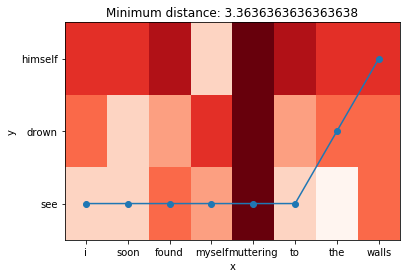

In [1]:
from numpy import array, zeros, argmin, inf, ndim
from scipy.spatial.distance import cdist


def dtw(x, y, dist, warp=1):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.
    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure
    :param int warp: how many shifts are computed.
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:]  # view
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j])
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            min_list = [D0[i, j]]
            for k in range(1, warp + 1):
                i_k = min(i + k, r - 1)
                j_k = min(j + k, c - 1)
                min_list += [D0[i_k, j], D0[i, j_k]]
            D1[i, j] += min(min_list)
    if len(x)==1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return D1[-1, -1] / sum(D1.shape), C, D1, path


def fastdtw(x, y, dist, warp=1):
    """
    Computes Dynamic Time Warping (DTW) of two sequences in a faster way.
    Instead of iterating through each element and calculating each distance,
    this uses the cdist function from scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html)
    :param array x: N1*M array
    :param array y: N2*M array
    :param string or func dist: distance parameter for cdist. When string is given, cdist uses optimized functions for the distance metrics.
    If a string is passed, the distance function can be 'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'wminkowski', 'yule'.
    :param int warp: how many shifts are computed.
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    if ndim(x) == 1:
        x = x.reshape(-1, 1)
    if ndim(y) == 1:
        y = y.reshape(-1, 1)
    r, c = len(x), len(y)
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:]
    D0[1:, 1:] = cdist(x, y, dist)
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            min_list = [D0[i, j]]
            for k in range(1, warp + 1):
                min_list += [D0[min(i + k, r - 1), j],
                             D0[i, min(j + k, c - 1)]]
            D1[i, j] += min(min_list)
    if len(x) == 1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return D1[-1, -1] / sum(D1.shape), C, D1, path


def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while (i > 0) or (j > 0):
        tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            i -= 1
        else:  # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)


if __name__ == '__main__':
    if 0:  # 1-D numeric
        from sklearn.metrics.pairwise import manhattan_distances
        x = [0, 0, 1, 1, 2, 4, 2, 1, 2, 0]
        y = [1, 1, 1, 2, 2, 2, 2, 3, 2, 0]
        dist_fun = manhattan_distances
    elif 0:  # 2-D numeric
        from sklearn.metrics.pairwise import euclidean_distances
        x = [[0, 0], [0, 1], [1, 1], [1, 2], [2, 2], [4, 3], [2, 3], [1, 1], [2, 2], [0, 1]]
        y = [[1, 0], [1, 1], [1, 1], [2, 1], [4, 3], [4, 3], [2, 3], [3, 1], [1, 2], [1, 0]]
        dist_fun = euclidean_distances
    else: # 1-D list of strings
        from nltk.metrics.distance import edit_distance
        # x = ['we', 'shelled', 'clams', 'for', 'the', 'chowder']
        # y = ['class', 'too']
        x = ['i', 'soon', 'found', 'myself', 'muttering', 'to', 'the', 'walls']
        y = ['see', 'drown', 'himself']
        # x = 'we talked about the situation'.split()
        # y = 'we talked about the situation'.split()
        dist_fun = edit_distance
    dist, cost, acc, path = dtw(x, y, dist_fun)

    # Vizualize
    from matplotlib import pyplot as plt
    plt.imshow(cost.T, origin='lower', cmap=plt.cm.Reds, interpolation='nearest')
    plt.plot(path[0], path[1], '-o') # relation
    plt.xticks(range(len(x)), x)
    plt.yticks(range(len(y)), y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('tight')
    plt.title('Minimum distance: {}'.format(dist))
plt.show()

In [2]:
import numpy as np
import pandas as pd
import pylab as pl

%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [3]:
def znormalization(ts):
    """
    ts - each column of ts is a time series (np.ndarray)
    """
    mus = ts.mean(axis = 0)
    stds = ts.std(axis = 0)
    return (ts - mus) / stds

In [4]:
ts1 = np.array([2.02, 2.33, 2.99, 6.85, 9.20, 8.80, 7.50, 6.00, 5.85, 3.85, 4.85, 3.85, 2.22, 1.45, 1.34]).reshape(-1,1)
ts2 = np.array([0.50, 1.29, 2.58, 3.83, 3.25, 4.25, 3.83, 5.63, 6.44, 6.25, 8.75, 8.83, 3.25, 0.75, 0.72]).reshape(-1,1)


In [5]:
def paa_transform(ts, n_pieces):
    """
    ts: the columns of which are time series represented by e.g. np.array
    n_pieces: M equally sized piecies into which the original ts is splitted
    """
    splitted = np.array_split(ts, n_pieces) ## along columns as we want
    return np.asarray(map(lambda xs: xs.mean(axis = 0), splitted))

In [6]:
import math
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import itertools as itools
import matplotlib.pyplot as plt
sns.set_style("dark")




In [7]:
t1 = np.array([2.02, 2.33, 2.99, 6.85, 9.20, 8.80, 7.50, 6.00, 5.85, 3.85, 4.85, 3.85, 2.22, 1.45, 1.34,0.5,1.8,2,2.2,3.5,6,8,1,5,7,9,1,5,7,8,0,1,4,6,7,8]).reshape(-1,1)
t2 = np.array([3.12, 2.02, 2.33, 2.99, 6.85, 9.20, 8.80, 7.50, 6.00, 5.85, 3.85, 4.85, 3.85, 2.22, 1.45,1.34,1.8,2.2,3.5,6,8,1,5,7,9,1,5,7,8,0,1,4,6,7,8]).reshape(-1,1)

In [8]:
def paa(arr, sections):
    try:
        assert arr.shape[0] != sections
    except AssertionError as e:
        return np.copy(arr)
    else:
        if arr.shape[0] % sections == 0:
            sectionarr = np.array_split(arr, sections)
            res = np.array([item.mean() for item in sectionarr])
            res = np.array(
                [sample for item in res for sample in 
                [item.mean()] * item.shape[0]]
            )
        else:
            sectionarr = np.zeros(sections)
            space_size = np.arange(0, arr.shape[0] * sections - 1)
            outputIndex = space_size // arr.shape[0]
            inputIndex = space_size // sections
            uniques, nUniques = np.unique(outputIndex, return_counts=True)
            
            res = [arr[indices].sum() / arr.shape[0] for indices in
                   np.split(inputIndex, nUniques.cumsum())[:-1]]
            indices = ([row.mean() for row in np.split(inputIndex, nUniques.cumsum())[:-1]])
    return res

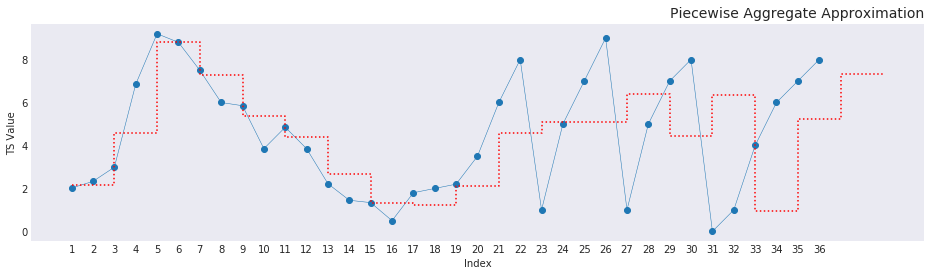

In [49]:


plt.figure(figsize=(16, 4))
plt.title("Piecewise Aggregate Approximation", size=14, loc="right")
plt.plot(range(1, 37), t1, marker="o", linewidth=0.5)
res = paa(t1, 19)
plt.step([1, 3, 5, 7, 9, 11, 13, 15,17,19,21,23,25,27,29,31,33,35,37,39], np.insert(res, 0, res[0]),
         color="red", linestyle=":")
plt.xticks(range(1, 37))
plt.xlabel("Index")
plt.ylabel("TS Value")
plt.savefig("./PAAStepFinal.png", bbox_inches="tight")
plt.show()



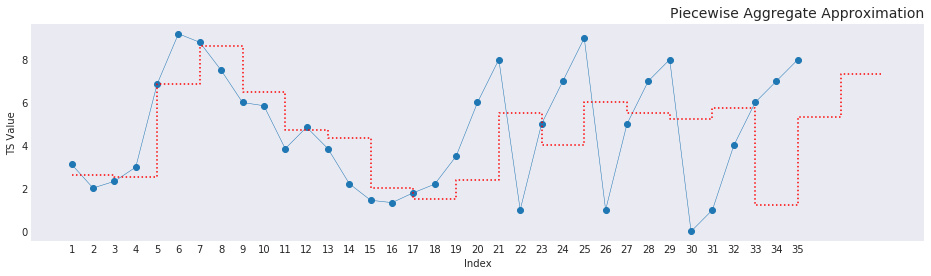

In [10]:


plt.figure(figsize=(16, 4))
plt.title("Piecewise Aggregate Approximation", size=14, loc="right")
plt.plot(range(1, 36), t2, marker="o", linewidth=0.5)
res1 = paa(t2, 19)
plt.step([1, 3, 5, 7, 9, 11, 13, 15,17,19,21,23,25,27,29,31,33,35,37,39], np.insert(res1, 0, res1[0]),
         color="red", linestyle=":")
plt.xticks(range(1, 36))
plt.xlabel("Index")
plt.ylabel("TS Value")
plt.savefig("./PAAStepFinal.png", bbox_inches="tight")
plt.show()



In [11]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/fractaluser/downloads/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['dist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


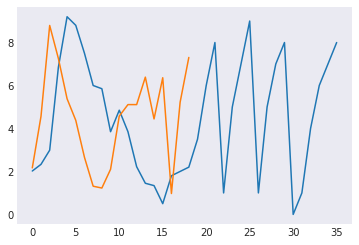

In [12]:
plot(t1)
plot(res)

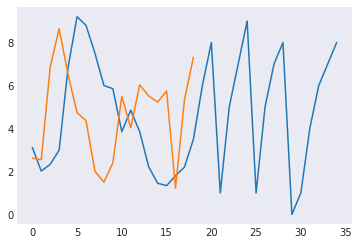

In [13]:
plot(t2)
plot(res1)

In [14]:
x= np.array(res).reshape(-1,1)
y= np.array(res1).reshape(-1,1)

In [80]:
dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))



TypeError: 'module' object is not callable

In [81]:
print('Minimum distance found:', dist)

Minimum distance found: 0.0301408450704


(-0.5, 34.5)

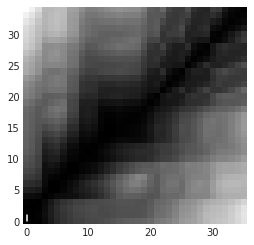

In [82]:
imshow(acc.T, origin='lower', cmap=cm.gray, interpolation='nearest')
plot(path[0], path[1], 'w')
xlim((-0.5, acc.shape[0]-0.5))
ylim((-0.5, acc.shape[1]-0.5))

In [18]:
x1=t1
y1=t2

In [19]:
dist, cost, acc, path = dtw(x1, y1, dist=lambda x1, y1: norm(x1 - y1, ord=1))

In [20]:
print('Minimum distance found:', dist)

Minimum distance found: 0.0301408450704


(-0.5, 34.5)

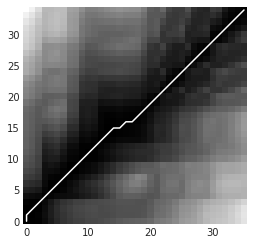

In [21]:
imshow(acc.T, origin='lower', cmap=cm.gray, interpolation='nearest')
plot(path[0], path[1], 'w')
xlim((-0.5, acc.shape[0]-0.5))
ylim((-0.5, acc.shape[1]-0.5))

(<matplotlib.figure.Figure at 0x7f6d1e3e12e8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6d1e40c198>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6d1e3876d8>], dtype=object))

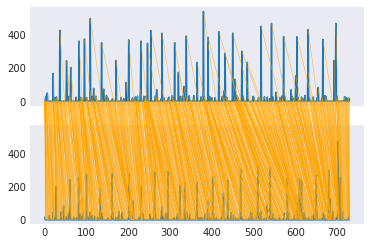

In [83]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np
path = dtw.warping_path(x, y)
dtwvis.plot_warping(x, y, path, filename="warp.png")

In [84]:
from dtaidistance import dtw

distance, paths = dtw.warping_paths(x, y)
print(distance)
print(paths)

978.407932622
[[    0.                    inf            inf ...,            inf
             inf            inf]
 [           inf    15.80960536    15.80960536 ...,  1423.53724743
   1423.74519753  1423.74519753]
 [           inf    22.35815832    15.80960536 ...,  1423.53724743
   1423.74519753  1423.74519753]
 ..., 
 [           inf  2089.05026299  2087.94092974 ...,   978.53924544
    978.76283527   978.22202615]
 [           inf  2089.05281074  2088.02803531 ...,   978.56180094
    978.5533864    978.40793262]
 [           inf  2089.11263212  2088.02803531 ...,   978.64071961
    978.85587433   978.40793262]]


(<matplotlib.figure.Figure at 0x7f6d21e944a8>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f6d22276b00>])

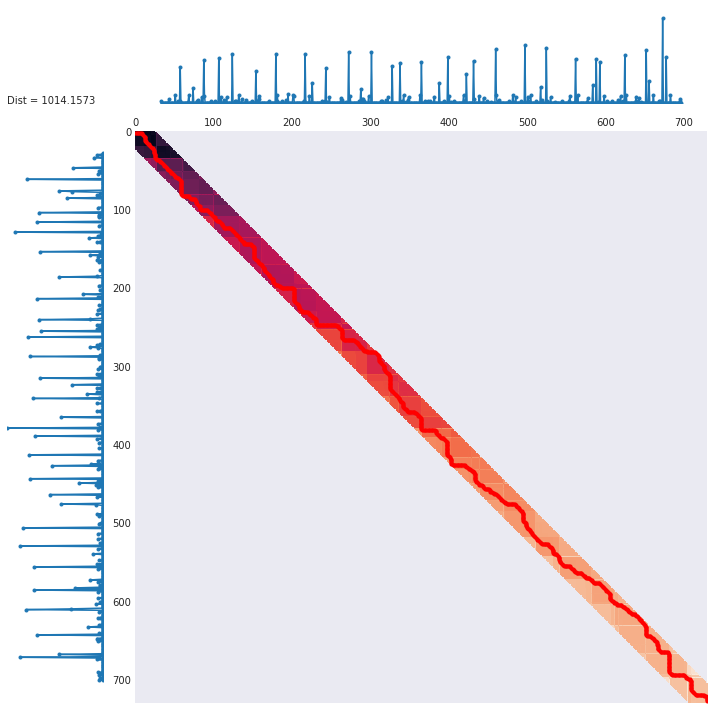

In [85]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np
d, paths = dtw.warping_paths(x, y, window=25, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(x, y, paths, best_path)

ValueError: x and y must have same first dimension, but have shapes (15,) and (5, 3)

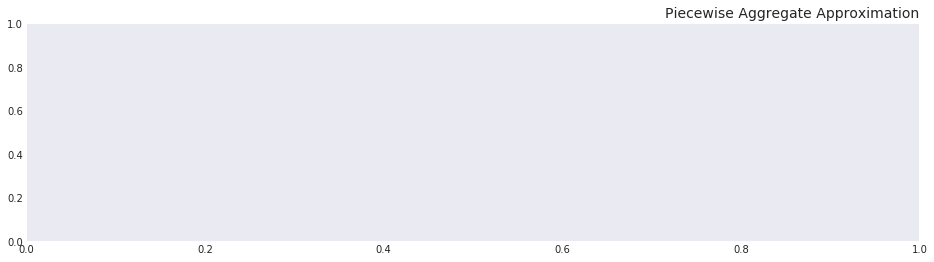

In [55]:
plt.figure(figsize=(16, 4))
plt.title("Piecewise Aggregate Approximation", size=14, loc="right")
plt.plot(range(1, 16), ts1, marker="o", linewidth=0.5)
res = paa(ts1, 7)
plt.step([1, 3, 5, 7, 9, 11, 13, 15,17,19,21,23,25,27,29,31,33,35,37,39,41], np.insert(res, 0, res[0]),
         color="red", linestyle=":")
plt.xticks(range(1, 16))
plt.xlabel("Index")
plt.ylabel("TS Value")
plt.savefig("./PAAStepFinal.png", bbox_inches="tight")
plt.show()

ValueError: x and y must have same first dimension, but have shapes (6,) and (20,)

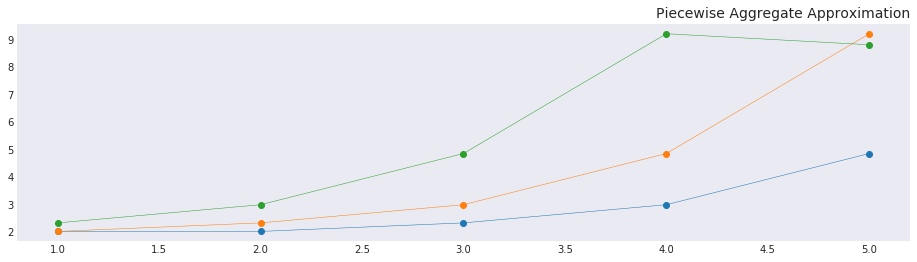

In [54]:
plt.figure(figsize=(16, 4))
plt.title("Piecewise Aggregate Approximation", size=14, loc="right")
plt.plot(range(1, 6), ts2, marker="o", linewidth=0.5)
res1 = paa(ts2, 3)
plt.step([1, 3, 5,7,9,11], np.insert(res, 0, res[0]),
         color="red", linestyle=":")
plt.xticks(range(1, 6))
plt.xlabel("Index")
plt.ylabel("TS Value")
plt.savefig("./PAAStepFinal.png", bbox_inches="tight")
plt.show()

In [27]:
x= np.array(res).reshape(-1,1)
y= np.array(res1).reshape(-1,1)

(<matplotlib.figure.Figure at 0x7f6d225c2eb8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6d225cb080>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6d2248a668>], dtype=object))

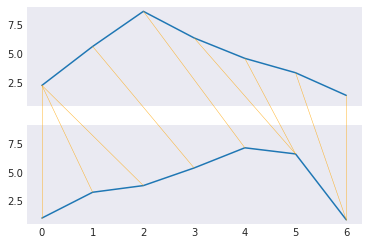

In [28]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np
path = dtw.warping_path(res, res1)
dtwvis.plot_warping(res, res1, path, filename="warp.png")

(<matplotlib.figure.Figure at 0x7f6d226f1048>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f6d22a04710>])

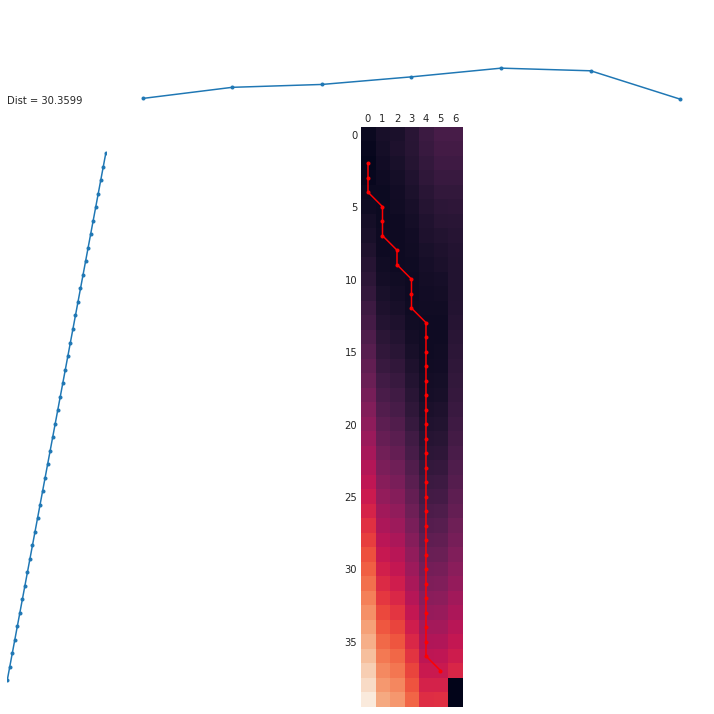

In [29]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np
x = np.arange(0, 20, .5)
d, paths = dtw.warping_paths(x, y, window=25, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(x, y, paths, best_path)

In [30]:
x


array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
         4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
         9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
        13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,
        18. ,  18.5,  19. ,  19.5])

In [31]:
y

array([[ 1.00733333],
       [ 3.25266667],
       [ 3.83266667],
       [ 5.366     ],
       [ 7.12133333],
       [ 6.58733333],
       [ 0.85466667]])

In [32]:
res

[2.2293333333333325,
 5.6193333333333335,
 8.6733333333333338,
 6.3599999999999985,
 4.583333333333333,
 3.3313333333333328,
 1.3606666666666667]

In [33]:
x= np.array(res).reshape(-1,1)
y= np.array(res1).reshape(-1,1)

In [34]:
def subsequences(ts, window):
    shape = (ts.size - window + 1, window)
    strides = ts.strides * 2
    return np.lib.stride_tricks.as_strided(ts, shape=shape, strides=strides)

In [41]:
p = subsequences(ts1,5)

In [42]:
p

array([[ 2.02,  2.33,  2.99,  6.85,  9.2 ],
       [ 2.33,  2.99,  6.85,  9.2 ,  8.8 ],
       [ 2.99,  6.85,  9.2 ,  8.8 ,  7.5 ],
       [ 6.85,  9.2 ,  8.8 ,  7.5 ,  6.  ],
       [ 9.2 ,  8.8 ,  7.5 ,  6.  ,  5.85],
       [ 8.8 ,  7.5 ,  6.  ,  5.85,  3.85],
       [ 7.5 ,  6.  ,  5.85,  3.85,  4.85],
       [ 6.  ,  5.85,  3.85,  4.85,  3.85],
       [ 5.85,  3.85,  4.85,  3.85,  2.22],
       [ 3.85,  4.85,  3.85,  2.22,  1.45],
       [ 4.85,  3.85,  2.22,  1.45,  1.34]])

In [37]:
ts1 = np.array([2.02, 2.33, 2.99, 6.85, 9.20, 8.80, 7.50, 6.00, 5.85, 3.85, 4.85, 3.85, 2.22, 1.45, 1.34])
ts2 = np.array([0.50, 1.29, 2.58, 3.83, 3.25, 4.25, 3.83, 5.63, 6.44, 6.25, 8.75, 8.83, 3.25, 0.75, 0.72])

In [48]:
ts1 = np.array([(2.02,2.02,2.33),(2.02,2.33,2.99),(2.33,2.99,6.85),(2.99,6.85,9.20),(6.85,9.20,8.80)])
ts2 = np.array([(2.02,2.02,2.33),(2.02,2.33,2.99),(2.33,2.99,4.85),(2.99,4.85,9.20),(4.85,9.20,8.80)])

In [ ]:
def subsequences(ts, window):
    shape = (ts.size - window + 1, window)
    strides = ts.strides * 2
    return np.lib.stride_tricks.as_strided(ts, shape=shape, strides=strides)
    

In [ ]:
def subsequences(ts, window):
    shape = (ts.size - window + 1, window)
    strides = ts.strides * 2
    return np.lib.stride_tricks.as_strided(ts, shape=shape, strides=strides)

In [45]:
p.strides

(8, 8)

In [ ]:
def subsequences1(ts,window):
    shape = (ts.size - window+1,window)
    

In [56]:
df = pd.read_csv('sample_simulated_transaction_history.csv')

In [57]:
df.date = pd.to_datetime(df.date)

In [58]:
df.head()

,id,date,purchaseamount,dept,category,chain,purchasequantity,company,brand,productsize,productmeasure
0,Test_1,2015-01-21,299.259191,Sports,Sports,site_1,1,Company2,Brand3,x,xx
1,Test_1,2016-01-03,291.480975,Sports,Sports,site_1,1,Company1,Brand1,x,xx
2,Test_1,2016-11-22,250.772741,Sports,Sports,site_1,1,Company1,Brand1,x,xx
3,Test_10,2015-05-06,212.223552,Sports,Sports,site_1,1,Company2,Brand2,x,xx
4,Test_10,2016-03-24,342.094726,Sports,Sports,site_1,1,Company1,Brand2,x,xx


In [59]:
df = df[(df.category == 'Blazers')].reset_index(drop = True)[['id','date', 'purchaseamount']]

NameError: name 'sample_data' is not defined

In [60]:
df = df.pivot_table(index=['id'], columns='date', values='purchaseamount', aggfunc='mean').fillna(0).T

In [61]:
df.head()

id,Donor_1,Donor_100,Donor_1000,Donor_1001,Donor_1002,Donor_1003,Donor_1004,Donor_1006,Donor_1007,Donor_101,...,Test_990,Test_991,Test_992,Test_993,Test_994,Test_995,Test_996,Test_997,Test_998,Test_999
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.000000,15.809605,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,45.303673,0.0,0.000000,36.833322,0.000000,243.588945,0.000000,0.0,0.0,0.000000
2015-01-02,0.000000,0.000000,26.471279,37.305068,0.0,0.000000,32.787628,0.0,14.105687,0.000000,...,0.000000,0.0,0.000000,27.536030,0.000000,27.284506,0.000000,0.0,0.0,0.000000
2015-01-03,29.787333,0.000000,0.000000,19.391885,0.0,33.192099,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,460.544118,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2015-01-04,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,10.088951,0.0,24.685659,16.691383,...,0.000000,0.0,0.000000,0.000000,31.584784,0.000000,0.000000,0.0,0.0,0.000000
2015-01-05,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,26.622136,0.000000,0.000000,107.751079,0.0,0.0,18.009434


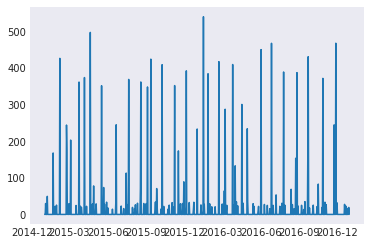

In [62]:
plot(df.Donor_1)

In [63]:
x = df.Donor_1

In [64]:
x

date
2015-01-01      0.000000
2015-01-02      0.000000
2015-01-03     29.787333
2015-01-04      0.000000
2015-01-05      0.000000
2015-01-06      0.000000
2015-01-07     49.391636
2015-01-08      0.000000
2015-01-09      0.000000
2015-01-10      0.000000
2015-01-11      0.000000
2015-01-12      0.000000
2015-01-13      0.000000
2015-01-14      0.000000
2015-01-15      0.000000
2015-01-16      0.000000
2015-01-17      0.000000
2015-01-18      0.000000
2015-01-19      0.000000
2015-01-20      0.000000
2015-01-21    167.925351
2015-01-22      0.000000
2015-01-23      0.000000
2015-01-24      0.000000
2015-01-25     21.782521
2015-01-26     11.677596
2015-01-27      0.000000
2015-01-28      0.000000
2015-01-29     25.465567
2015-01-30      0.000000
                 ...    
2016-12-01     31.625505
2016-12-02      0.000000
2016-12-03      0.000000
2016-12-04      0.000000
2016-12-05      0.000000
2016-12-06      0.000000
2016-12-07      0.000000
2016-12-08      0.000000
2016-12-09      0.00

In [65]:
y = df.Donor_100

In [76]:
x= np.array(df.Donor_1)

In [77]:
x

array([   0.        ,    0.        ,   29.78733304,    0.        ,
          0.        ,    0.        ,   49.39163619,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
        167.92535145,    0.        ,    0.        ,    0.        ,
         21.78252097,   11.67759603,    0.        ,    0.        ,
         25.46556709,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
        426.53164312,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
        244.21759619,  174.52683321,    0.        ,   14.49332095,
          0.        ,    0.        ,   29.39588283,   22.12352

In [78]:
y= np.array(df.Donor_100)

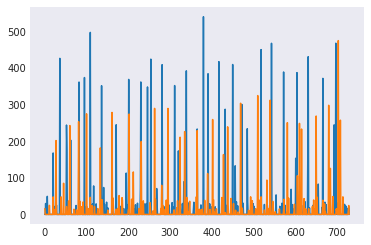

In [79]:
plot(x)
plot(y)

In [86]:
p = array([   0.        ,    0.        ,   29.78733304,    0.        ,
          0.        ,    0.        ,   49.39163619,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
        167.92535145,    0.        ,    0.        ,    0.        ,
         21.78252097,   11.67759603,    0.        ,    0.        ,
         25.46556709])

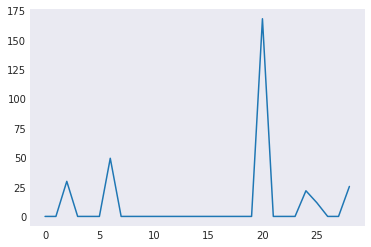

In [87]:
plot(p)

In [88]:
y

array([  15.80960536,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,   24.87971222,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
         47.85923036,    0.        ,    0.        ,    0.        ,
         13.28719091,    0.        ,   15.5234475 ,  201.83426337,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    9.9575391 ,   47.91548108,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,   85.12444249,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,   15.50083256,
         21.60200069,    0.        ,    0.        ,    0.        ,
          0.        ,   36.53254149,    0.        ,    0.     

In [89]:
q = array([  15.80960536,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,   24.87971222,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
         47.85923036,    0.        ,    0.        ,    0.        ,
         13.28719091,    0.        ,   15.5234475 ,  201.83426337,
          0.     ])

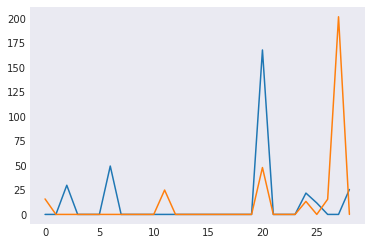

In [90]:
plot(p)
plot(q)

(<matplotlib.figure.Figure at 0x7f6d18ada6d8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6d18efce48>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6d18e021d0>], dtype=object))

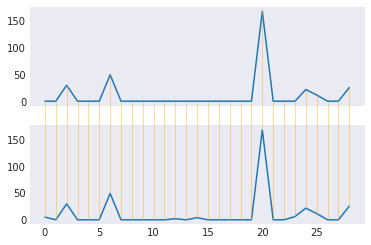

In [109]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np
path = dtw.warping_path(p, q)
dtwvis.plot_warping(p, q, path, filename="warp.png")

(<matplotlib.figure.Figure at 0x7f6d18adab00>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f6d18a08208>])

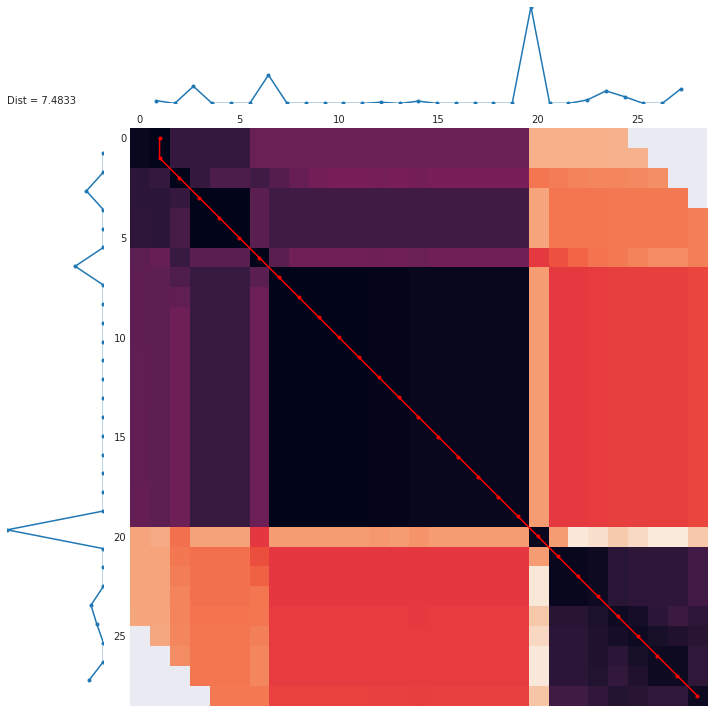

In [108]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np

d, paths = dtw.warping_paths(p, q, window=25, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(p, q, paths, best_path)

In [93]:
from dtaidistance import dtw

distance, paths = dtw.warping_paths(x, y)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2015-01-01 to 2016-12-30
Columns: 6000 entries, Donor_1 to Test_999
dtypes: float64(6000)
memory usage: 33.4 MB


In [99]:
df1 = df.apply(np.array)

df1

id,Donor_1,Donor_100,Donor_1000,Donor_1001,Donor_1002,Donor_1003,Donor_1004,Donor_1006,Donor_1007,Donor_101,...,Test_990,Test_991,Test_992,Test_993,Test_994,Test_995,Test_996,Test_997,Test_998,Test_999
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.000000,15.809605,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,45.303673,0.000000,0.000000,36.833322,0.000000,243.588945,0.000000,0.000000,0.000000,0.000000
2015-01-02,0.000000,0.000000,26.471279,37.305068,0.000000,0.000000,32.787628,0.000000,14.105687,0.000000,...,0.000000,0.000000,0.000000,27.536030,0.000000,27.284506,0.000000,0.000000,0.000000,0.000000
2015-01-03,29.787333,0.000000,0.000000,19.391885,0.000000,33.192099,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,460.544118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.088951,0.000000,24.685659,16.691383,...,0.000000,0.000000,0.000000,0.000000,31.584784,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,26.622136,0.000000,0.000000,107.751079,0.000000,0.000000,18.009434
2015-01-06,0.000000,0.000000,0.000000,0.000000,0.000000,478.584491,0.000000,113.707531,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,192.118579,14.402879,63.661271,0.000000,0.000000,0.000000
2015-01-07,49.391636,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48.402404,0.000000,0.000000,0.000000
2015-01-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,16.479885,33.603907,0.000000,0.000000,0.000000
2015-01-09,0.000000,0.000000,0.000000,0.000000,139.239062,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,34.222546,0.000000,0.000000,0.000000,36.411120,0.000000,24.869092,36.387802,446.593166


In [101]:
from dtaidistance import dtw
import numpy as np
series = [
    np.array(df.Donor_1),
    np.array(df.Donor_100),
    np.array(df.Donor_1000)]
ds = dtw.distance_matrix_fast(series)

In [102]:
ds

array([[           inf,   978.40793262,  1041.93038701],
       [           inf,            inf,   725.89615346],
       [           inf,            inf,            inf]])

(<matplotlib.figure.Figure at 0x7f6d18e23b00>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f6d18e8a5f8>])

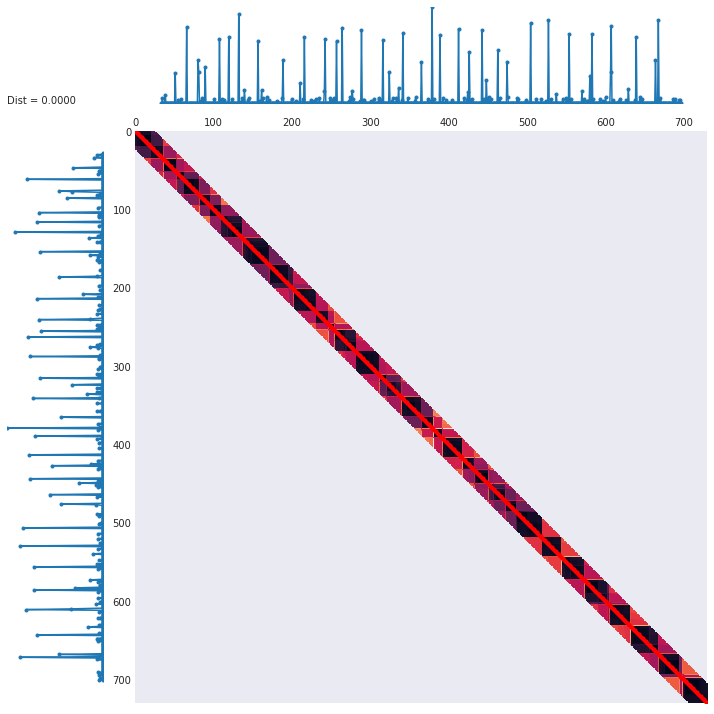

In [103]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np
d, paths = dtw.warping_paths(x, x, window=25, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(x, x, paths, best_path)

(<matplotlib.figure.Figure at 0x7f6d18ed4128>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6d18ea1c88>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6d18de62b0>], dtype=object))

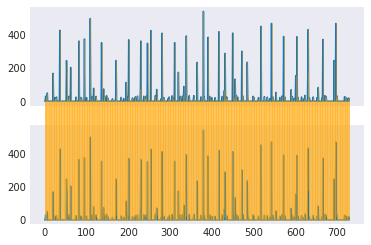

In [104]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np
path = dtw.warping_path(x, x)
dtwvis.plot_warping(x, x, path, filename="warp.png")

In [105]:
x

array([   0.        ,    0.        ,   29.78733304,    0.        ,
          0.        ,    0.        ,   49.39163619,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
        167.92535145,    0.        ,    0.        ,    0.        ,
         21.78252097,   11.67759603,    0.        ,    0.        ,
         25.46556709,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
        426.53164312,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
        244.21759619,  174.52683321,    0.        ,   14.49332095,
          0.        ,    0.        ,   29.39588283,   22.12352

In [106]:
p

array([   0.        ,    0.        ,   29.78733304,    0.        ,
          0.        ,    0.        ,   49.39163619,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
        167.92535145,    0.        ,    0.        ,    0.        ,
         21.78252097,   11.67759603,    0.        ,    0.        ,
         25.46556709])

In [107]:
q= array([   5        ,    0.        ,   29.78733304,    0.        ,
          0.        ,    0.        ,   49.39163619,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          2       ,    0.        ,    4       ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
        167.92535145,    0.        ,    0.        ,    6      ,
         21.78252097,   11.67759603,    0.        ,    0.        ,
         25.46556709])